In [6]:
import requests
import pandas as pd
import datetime
from datetime import date, timedelta
import json
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

In [7]:
headers = {'usertoken': '{}'.format(os.environ['user_token'])}

In [8]:
def get_data():
    dates = []
    dataframes = []
    now = datetime.datetime.now()
    today = now.strftime("%Y-%m-%d")

    d1 = '2019-01-01'
    d2 = '2019-05-08'
    date1 = date(int(d1.split('-')[0]), int(d1.split('-')[1]), int(d1.split('-')[-1]))
    date2 = date(int(d2.split('-')[0]), int(d2.split('-')[1]), int(d2.split('-')[-1]))
    delta = date2 - date1
    for i in range(delta.days):
        dates.append(str(date1 + timedelta(i)))

    for day in dates:
        url = "{}{}&endDate={}".format(os.environ['performance_endpoint'],str(day), (day))
        print(url)
        r = requests.get(url, headers=headers)
        result = json.loads(r.content)

        df = pd.DataFrame(result)
        try:
            df['drivingDuration'] = df['drivingDuration'].apply(lambda x: str(datetime.timedelta(seconds=x)))
            df['engineDuration'] = df['engineDuration'].apply(lambda x: str(datetime.timedelta(seconds=x)))
            df['idlingDuration'] = df['idlingDuration'].apply(lambda x: str(datetime.timedelta(seconds=x)))
            df['date'] =  day
            df.rename(index=str, columns={'dgeDist': 'Miles/DGE', 'dgeHr': 'DGE/Hr',
                                              'dispatchTypeId': 'Dispatch Type', 'drivingDuration': 'Driving Duration (Hrs)',
                                              'drivingPrcntg': 'Driving %', 'engineDuration': 'Engine Duration (Hrs)',
                                              'fuelEconomyDist': 'MPG',
                                              'fuelEconomyHr': 'Gal/Hr', 'idlingDuration': 'Idle Duration (Hrs)',
                                              'idlingPrcntg': 'Idle Percentage', 'key': 'Truck Name', 'totalDGE': 'Total DGE',
                                              'totalDistance': 'Total Distance', 'totalFuel': 'Fuel Used (Gal)'}, inplace=True)
            df.to_csv('truck_performance\\{}.csv'.format(day))
        except KeyError as e:
            df.to_csv('truck_performance\\{}_except.csv'.format(day))

            

In [9]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [ ]:
# Parse csv output into pandas dataframes, and concatenate into single dataframe.
get_data()
path = 'truck_performance\\'
all_files = glob.glob(path + "/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
merged_df = pd.concat(li, axis=0, ignore_index=True)
merged_df['date'] =  pd.to_datetime(merged_df['date'], format='%Y-%m-%d')
merged_df['day'] = merged_df['date'].dt.weekday_name

In [11]:
# Remove erroneous data, and Saturday/Sunday for daily average calculations
merged_positive = merged_df.loc[(merged_df['MPG'] > 0) &
                                (merged_df['day'] != 'Sunday') &
                                (merged_df['day'] != 'Saturday') &
                                (merged_df['Total Distance'] > 2)]

In [12]:
merged_grouped = merged_positive.resample('D', on='date').median().dropna()

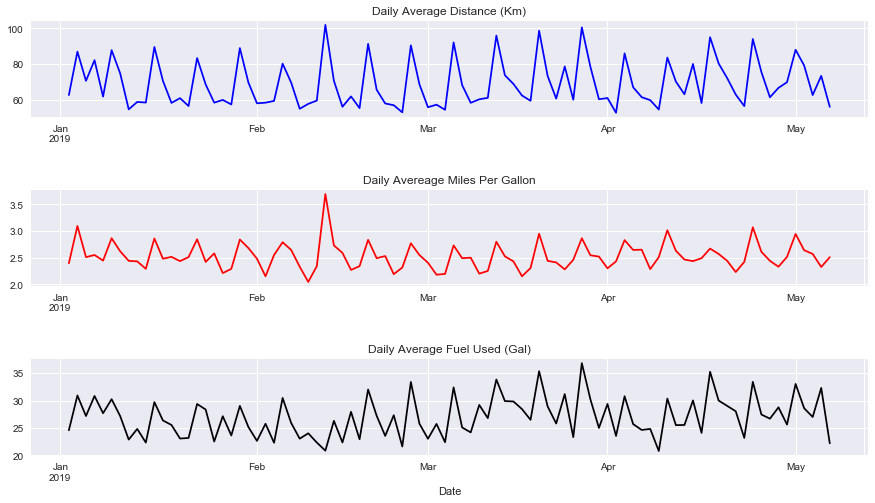

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

merged_grouped['Total Distance'].plot(figsize=(15,8), ax=ax1, title='Daily Average Distance (Km)', cmap='winter')
ax1.xaxis.set_label_text("")
merged_grouped['MPG'].plot(figsize=(15,8), ax=ax2, title='Daily Avereage Miles Per Gallon', cmap='autumn')
ax2.xaxis.set_label_text("")
merged_grouped['Fuel Used (Gal)'].plot(figsize=(15,8), ax=ax3, title='Daily Average Fuel Used (Gal)', cmap='magma')
ax3.xaxis.set_label_text("Date")

fig.subplots_adjust(hspace=.75)
plt.show()

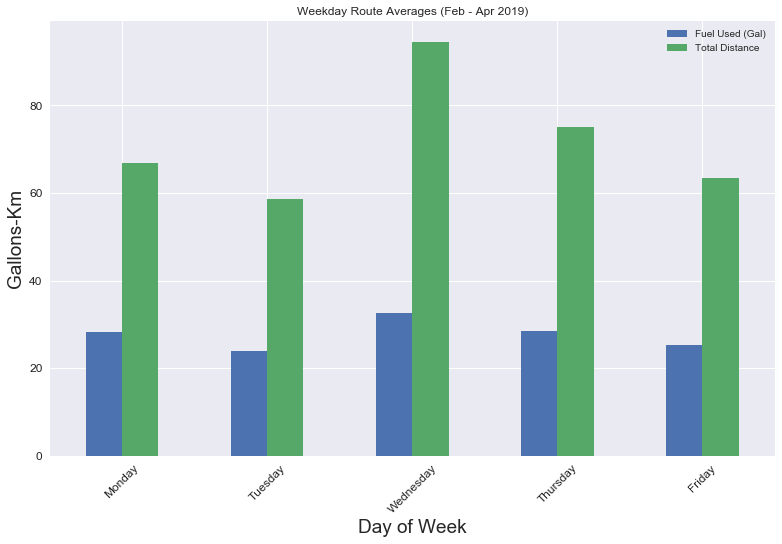

In [14]:
"""Weekday Averages"""

days_grouped = merged_positive.groupby(merged_positive['day']).mean()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
days_grouped = days_grouped.loc[day_order]
ax = days_grouped[['Fuel Used (Gal)',
                   'Total Distance']].plot(kind='bar', 
                                           title ="Weekday Route Averages (Feb - Apr 2019)",
                                           figsize=(13,8),
                                           legend=True, fontsize=12)
ax.set_xlabel("Day of Week", fontsize=19)
ax.set_ylabel("Gallons-Km", fontsize=19)
plt.xticks(rotation=45)
plt.show()

In [15]:
# Lets look at the individual truck's fuel usage patterns to try and find more patterns..
truck_df = merged_positive.groupby(merged_positive['Truck Name']).mean()

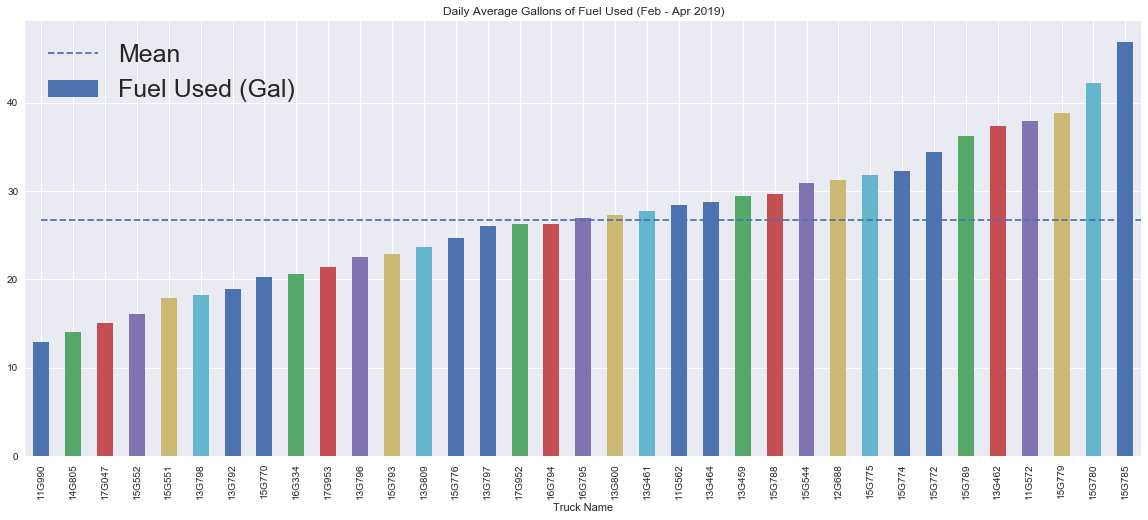

In [16]:
"""Truck Daily Average Gallons of Fuel Used"""
import plotly
import plotly.plotly as py
import plotly.tools as tls

import matplotlib.pyplot as plt
import numpy as np
import datetime

y_mean = [np.mean(truck_df['Fuel Used (Gal)'])]*len(truck_df.index)


error_config = {'ecolor': '0.3'}
truck_df = truck_df.sort_values('Fuel Used (Gal)')
ax = truck_df['Fuel Used (Gal)'].iloc[1::2].plot(kind='bar', title ="Daily Average Gallons of Fuel Used (Feb - Apr 2019)",
                                      figsize=(20,8))
mean_line = ax.plot(y_mean, label='Mean', linestyle='--')
legend = ax.legend(loc='upper left', prop={'size': 25})
plt.show()

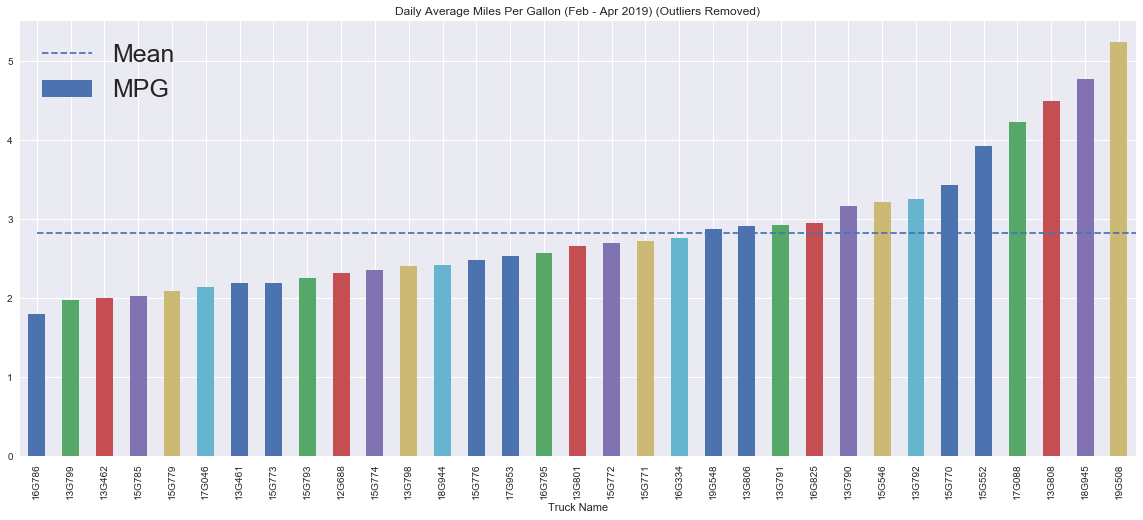

In [17]:
"""Truck Daily Average Miles Per Gallon"""

# Remove outliers
truck_df['MPG'] = truck_df['MPG'][~is_outlier(truck_df['MPG'])]
truck_df.dropna(inplace=True)

y_mean = [np.mean(truck_df['MPG'])]*len(truck_df.index)

# Plot mean MPG
truck_df = truck_df.sort_values('MPG')
ax = truck_df['MPG'].iloc[1::2].plot(kind='bar', title ="Daily Average Miles Per Gallon (Feb - Apr 2019) (Outliers Removed)",
                          figsize=(20,8))
mean_line = ax.plot(y_mean, label='Mean', linestyle='--')
legend = ax.legend(loc='upper left', prop={'size': 25})
plt.show()